<center>

# Common Mistakes in Measurement Machine Correlation

Zhang Zhou  
2024-01-26
</center>

---

##### **Abstract**

Machine correlation seems simple, which can be easily done with linear regression fitting. However, by doing virtual experiments using random numbers, we demonstrate the common mistakes such as wrong interpretation of $\small R^2$ score and system error from OLS linear regression model. Without confusing math derivation, we explain the concept using layman language and also recommend best practices for machine correlation job sample preperation and data processing.

## Background

Measurement machine correlation is a common yet critical task in many industries. Without much background in statistics and machine learning models, many practioners simply use `Excel` scatter plot with linear trend line to find the correlation coefficients. Below is an example:

<center>
<figure>
<img src="Images/fig 01.png" style="width:100%">
<figcaption align = "center"> Fig 1: Correlation using Excel </figcaption>
</figure>
</center>

This method works fine most of the time, but sometimes it is not easy to collect good uniformly distributed data and the correlation quality may be a concern.

Some difficulties in real industry environment:

**1. High variance**
* Gauge repeatability and reproducibility (GR&R) shows the capability of using a specific gauge (measurement machine / method) to control product parameter in a designed spec.

* If statistical process control system is applied in the manufacturing environment, a product parameter spec is typically set within 6 sigma range. 1 sigma equals to the standard deviation of this product parameter using the designed process. So the spec range is `design center +/- 3 sigma`.

* By industry standard, idea GR&R should be less than 10% of spec range. If it is difficult to meet, up to 30% GR&R is acceptable. This means both the measurement system (including machine and operator) variance and sample variance can be very significant to affect the correlation quality.

**2. Sample size limit**
* While bigger sample size uniformly distributed in a wider range usually yields better correlation fitting quality, it is difficult to achieve in production environment.

* **Sample preparation limit**
  * It can be costly to prepare sample for correlation purpose, especially when you need to tune process to make specially samples whose parameter is close or exceed spec limit. Sometimes it is difficult to allocate long line down time so you have to limit the number of parameter steps. Typically samples with 7 steps or more are preferred, 5 steps are OK. At some extreme conditions, you have to work with only 3 steps. 

* **Measurement limit**
  * Sometimes it is just not feasible to measure too many samples.
    * If the measurement of 1 sample takes 30 min, it is not possible to measure tens or hundreds of samples just for correlation purpose while the machine still needs to actively support production activities.
    * Sometimes machine correlation needs to redo after maintainence or consumable part change. If one consumable part can only last 2000 hrs and one sample measurement takes 0.5 hr, it is also not reasonable to waste hundreds of hrs part life just to do correlation.

**3. Others**
  * Some measurement is **destructive**, meaning you cannot use the same sample to measure on the other machine to get apple to apple comparison.
    * Typical walk around is to pick samples from same box (or same batch, same line, etc.). The assumption is they have relatively smaller variance.
  * Sometimes the samples may have very **short shelf life** and measurements have to be done quickly after they are produced, thus limiting the number of data points for correlation work.

## Objective

Consider the above difficulties in real industry environment, I'd like to study if the simple correlation method using `Excel` is valid and accurate. If not, how to improve.

I won't dive into math derivation, which can be confusing. Instead, I use random number generator to simulate measurement result. In this way, we can easily observe the effect of experiment design (parameter step, sample size, etc.) and different correlation methods.

### `Excel`'s linear fitting method

Before starting our experiment, let's review the curve fitting method used in `Excel` and how we can simulate it by `Python`.

The linear regression method used in Excel's trendline feature is Ordinary Least Squares (OLS). In `Python`, we can use `OLS` model from `statsmodels` package to do the same calculation. 

Below codes shows the fitting result using the same data in ***Fig 1***

In [1]:
# Environment setup

## Load packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS, WLS, GLS
from sklearn.neighbors import KernelDensity

from scipy import stats

## Plug seed in random number generator for repeatability
rng = np.random.default_rng(seed=42)

## I like default seaborn theme
sns.set_theme()

## suppress warning messages in output
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Compare statsmodels ols model to Excel linear regression

# Read in data from Excel file
file_path = 'Charts.xlsx'
data = pd.read_excel(file_path, 
                     sheet_name='Example correlation plot', 
                     usecols='B:C',
                     header=1,
                     nrows=15)
data.columns = ['X', 'Y']

# Build model
X = sm.add_constant(data.X)
model = OLS(data.Y, X).fit()

# Print result in Excel style
print(f'y = {model.params["X"]:.3f}x + {model.params["const"]:.3f}')
print(f'R2 = {model.rsquared:.3f}')

y = 1.918x + 3.499
R2 = 0.839


The result is same as `Excel`.

### Virtual Experiment Setup

**Assumptions**  
* Machines: **X** (master tool) and **Y** (eval tool)
* Parameter spec (based on machine X reading): **10.0 +/- 0.3**
  * Center point = 10.0
  * Process overall sigma (standard deviation) = 0.1
  * Same box sample (aka. sister sample) sigma (standard deviation) = **0.0548** (30% of overall variance)
* Real correlation: **y = 1.1x + 0.1**
  * In below virtual experiments, we will compare the estimated correlation coefficients to the real ones.
  * In real experiments, you will NOT know the real coefficients.
  * In real life, the correlation between 2 machines is rarely linear, even if they are same brand and model. However it is usually reasonable to assume linear relationship in a small range. For machine correlation, the range of interest is parameter spec range (center +/- 3 sigmal) or slightly wider (e.g. center +/- 6 sigmal).
* Machine X measurement standard deviation: **0.0316** (10% of process variance)
* Machine Y measurement standard deviation: **0.0548** (30% of process variance)

For each virtual experiment, **1000** groups of simulated measurement results by machine X and Y are randomly generated. Based on 1000 fitting results we can compare the distribution of the correlation coefficients.

In [3]:
# Virtual measurement data generator

## define global variables
design_center = 10.0
process_sigma = 0.1
sister_sigma = np.sqrt(process_sigma**2 * 0.3)
slope_true = 1.1
intercept_true = 0.1
X_sigma = np.sqrt(process_sigma**2 * 0.1) # Machine X measurement sigma
Y_sigma = np.sqrt(process_sigma**2 * 0.3)
exp_n = 1000 # number of experiments

## Making samples
def make_samples(target, n, get_sister=False):
    """Simulate sample making process

    Return
    ---
        * samples [array] -- if (get_sister==False) 
        * (samples [array], sisters [array]) -- if (get_sister==True)

    NOTE
    ---
        * The returned values simulate sample true values.
        * In reality you can only see machine readings which include machine variance.

    Parameters
    ---
    - target [num]: target sample value
    - n [int]: number of samples to be made
    - get_sister [bool]: True if you want take sister samples from the same box
    """
    if get_sister == False:
        return rng.normal(loc=target, scale=process_sigma, size=n)
    else: # sister sample required
        boxes = rng.normal(loc=target, size=n,
                           scale=np.sqrt(process_sigma**2 - sister_sigma**2))
        samples = boxes + rng.normal(loc=0, size=n, scale=sister_sigma)
        sisters = boxes + rng.normal(loc=0, size=n, scale=sister_sigma)
        return samples, sisters

## Convert values from X machine based to Y machine based readings
def get_Y_based_values(X_based_values):
    """Convert machine X based values to machine Y based values

    Return
    ---
    - Y_based_values [np.array]

    Parameters
    ---
    - X_based_values [np.array]
    """
    return X_based_values * slope_true + intercept_true

## Measurement
def measurement(data, sigma):
    """Return machine measurement readings

    Return
    ---
    - readings [np.array]

    Parameters
    ---
    - data [np.array]: use the values based on the specific measurement machine
    - sigma [num]: standard deviation of the measurement machine
    """
    readings = data + rng.normal(loc=0, scale=sigma, size=data.shape)
    return readings

def meas_X(X_based_data):
    """Return machine X measurement readings
    - This func is a wrapping of [measurement] func

    Parameters
    ---
    - X_based_data [np.array]
    """
    return measurement(X_based_data, X_sigma)

def meas_Y(Y_based_data):
    """Return machine Y measurement readings
    - This func is a wrapping of [measurement] func

    Parameters
    ---
    - Y_based_data [np.array]
    """
    return measurement(Y_based_data, Y_sigma)

## Sample Steps *vs.* Sizes

**Scenario**  
 
QA engineer Albert is tasked to establish correlation between measurement machine X and Y. The range of interest is product spec range (correlation range needs to be wider, here we use design center +/- 6 sigma as example). Due to resource limit, he can only measure 105 samples. Tradionally a sample ladder is required, but he wonders how many steps can yield the best correlation result?

To help him solve this issue, let's design below 3 experiments:

* **Experiment 01**:
  * 3 steps: center, +/- 6 sigma
  * 35 samples per step
* **Experiment 02**:
  * 5 steps: center, +/- 3 sigma, +/- 6 sigma
  * 21 samples per step
* **Experiment 03**:
  * 7 steps: center, +/- 2 sigma, +/- 4 sigma, +/- 6 sigma
  * 15 samples per step

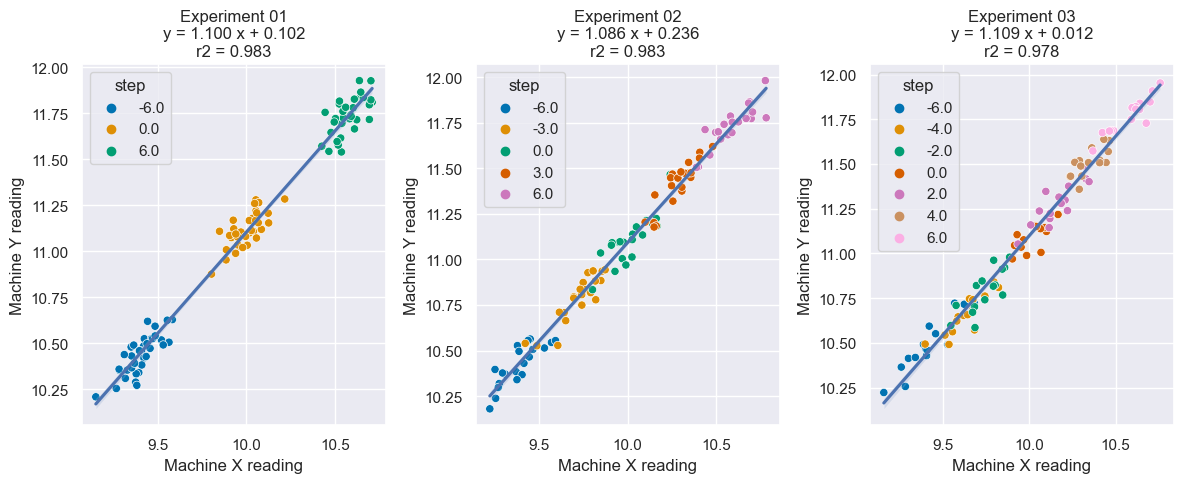

In [4]:
# Define experiment 1~3

def experiment(design, use_sister=False):
    """Do experiment once, without fitting

    Return
    ---
    - df [DataFrame]
      - columns: ['step', 'X_true', 'Y_true', 'X_reading', 'Y_reading']
    
    Parameters
    ---
    - design [list]: shape (n, 2)
      - [[shift1, n1], [shift2, n2], ...]
      - shift1 [float]: number of sigma from design center
      - n1 [int]: number of samples made at this target step value
    - use_sister [bool]: if sister sample is needed for machine Y measurement
    """
    X_true, Y_true = np.array([]), np.array([])
    steps = [] # record the sample is from which step
    for step in design:
        shift, n = step[0], step[1]
        steps = steps + [shift] * n
        samples = make_samples(target= design_center + shift * process_sigma, n=n,
                               get_sister=use_sister)
        if use_sister == True:
            X, Y = samples[0], samples[1]
        else: # not use sister sample
            X, Y = samples.copy(), samples.copy()
        Y = get_Y_based_values(Y)
        X_true = np.concatenate([X_true, X])
        Y_true = np.concatenate([Y_true, Y])
    df = pd.DataFrame({'step':steps, 'X_true':X_true, 'Y_true':Y_true})
    df['X_reading'] = meas_X(df['X_true'])
    df['Y_reading'] = meas_Y(df['Y_true'])
    return df

def linear_fit(df, using_GLS=False):
    """linear fit using OLS method by default

    Return
    ---
    - (slope [num], intercept [num], r2 [num])

    Parameter
    ---
    - df [DataFrame]
      - Must include columns: ['X_reading', 'Y_reading']
      - Optional column: ['weight']
    - using_GLS [bool]
    """
    X = sm.add_constant(df['X_reading'])
    if 'weight' in df.columns:
        model = WLS(df['Y_reading'], X, weights=df['weight']).fit()
    elif using_GLS == True:
        model = GLS(df['Y_reading'], X).fit()
    else:
        model = OLS(df['Y_reading'], X).fit()
    # print(model.params)
    return model.params['X_reading'], model.params['const'], model.rsquared

def exp01():
    """Do experiment 01 once, with fitting

    Return
    ---
    - (fit_results [tuple], df [DataFrame])
      - fit_results: (slope [num], intercept [num], r2 [num])
      - df: ['step', 'X_true', 'Y_true', 'X_reading', 'Y_reading']
    """
    design = [[-6.0, 35], [0.0, 35], [6.0, 35]]
    df = experiment(design)
    return linear_fit(df), df

def exp02():
    """Do experiment 02 once, with fitting

    Return
    ---
    - (fit_results [tuple], df [DataFrame])
      - fit_results: (slope [num], intercept [num], r2 [num])
      - df: ['step', 'X_true', 'Y_true', 'X_reading', 'Y_reading']
    """
    design = [[-6.0, 21], [-3.0, 21], [0.0, 21], [3.0, 21], [6.0, 21]]
    df = experiment(design)
    return linear_fit(df), df

def exp03():
    """Do experiment 03 once, with fitting

    Return
    ---
    - (fit_results [tuple], df [DataFrame])
      - fit_results: (slope [num], intercept [num], r2 [num])
      - df: ['step', 'X_true', 'Y_true', 'X_reading', 'Y_reading']
    """
    design = [[-6.0, 15], [-4.0, 15], [-2.0, 15], [0.0, 15], [2.0, 15], [4.0, 15], [6.0, 15]]
    df = experiment(design)
    return linear_fit(df), df

# Do experiment 1~3 once each, show plots
results = [exp01(), exp02(), exp03()]
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,5))
for i in range(3):
    (slope, intercept, r2), df = results[i]
    ax = axs[i]
    sns.scatterplot(df, x='X_reading', y='Y_reading', ax=ax, hue='step', palette='colorblind')
    sns.regplot(df, x='X_reading', y='Y_reading', ax=ax, scatter=False)
    ax.set_xlabel('Machine X reading')
    ax.set_ylabel('Machine Y reading')
    ax.set_title(f'Experiment {i+1:02d}\ny = {slope:.3f} x ' 
                 + ('+' if intercept>=0 else '-') 
                 + f' {abs(intercept):.3f}\nr2 = {r2:.3f}')
plt.tight_layout()
plt.show()

Above shows the result of experiment 1~3 once each. It is difficult to judge which design is better. Let's repeat them 1000 times each and compare the distribution of regression coefficients and r2 score.

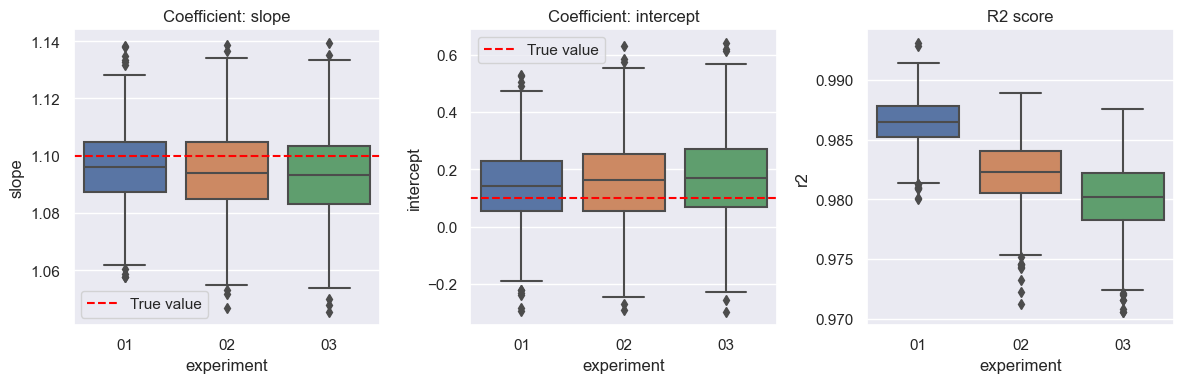

Experiment 1~3 Summary:


slope           intercept                  r2          
                mean       std      mean       std      mean       std
experiment                                                            
01          1.095837  0.012765  0.141735  0.127798  0.986438  0.001924
02          1.094323  0.014421  0.156810  0.144440  0.982184  0.002633
03          1.093636  0.015059  0.163711  0.151058  0.980143  0.002904

In [5]:
# Repeating experiment 1~3 each 1000 (or exp_n) times

exp_dict = {'01': exp01, '02': exp02, '03': exp03}
results_dict = {'experiment': [], 'slope': [], 'intercept': [], 'r2': []} # container of experiment results
exp_comment_dict = {'01': '3 steps, 35 pts per step, total 105 pts',
                    '02': '5 steps, 21 pts per step, total 105 pts',
                    '03': '7 steps, 15 pts per step, total 105 pts'}

for exp in exp_dict:
    for i in range(exp_n):
        slope, intercept, r2 = exp_dict[exp]()[0]
        results_dict['experiment'].append(exp)
        results_dict['slope'].append(slope)
        results_dict['intercept'].append(intercept)
        results_dict['r2'].append(r2)

# display results

df_results = pd.DataFrame(results_dict)
df_summary = df_results.groupby('experiment').agg(['mean', 'std'])

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
sns.boxplot(df_results, x='experiment', y='slope', ax=axs[0])
sns.boxplot(df_results, x='experiment', y='intercept', ax=axs[1])
sns.boxplot(df_results, x='experiment', y='r2', ax=axs[2])
axs[0].set_title('Coefficient: slope')
axs[1].set_title('Coefficient: intercept')
axs[2].set_title('R2 score')
axs[0].axhline(1.1, color='red', linestyle='--', label='True value')
axs[1].axhline(0.1, color='red', linestyle='--', label='True value')
axs[0].legend()
axs[1].legend()
plt.tight_layout()
plt.show()

print('Experiment 1~3 Summary:')
df_summary

Looks like there are some trends. But before jumping into conlusion, let's test if these trends are statistically significant or not.

**Hypothesis Test Method**

1.  **Independent samples t-test** is used to test if the parameter means of 2 experiments are different or not.
    - $H_0:$ The parameter means of these 2 experiments are same.  
    (null hypothesis)
    - $H_a:$ The parameter means of these 2 experiments are different.  
    (alternative hypothesis)
2.  **Bartlett’s test** is used to test if the parameter variations of 2 experiments are different or not.
    - $H_0:$ The parameter variations of these 2 experiments are same.
    - $H_a:$ The parameter variations of these 2 experiments are different.
3.  Confidence level: 95% (**α = 0.05**)
    - $H_0$ (null hypothesis) shall be rejected if $\small (p<\alpha)$

Both t-test and Bartlett’s test assume sample normality. Let's first check if this assumption is valid.

Experiment 01 fitting parameters normality check:


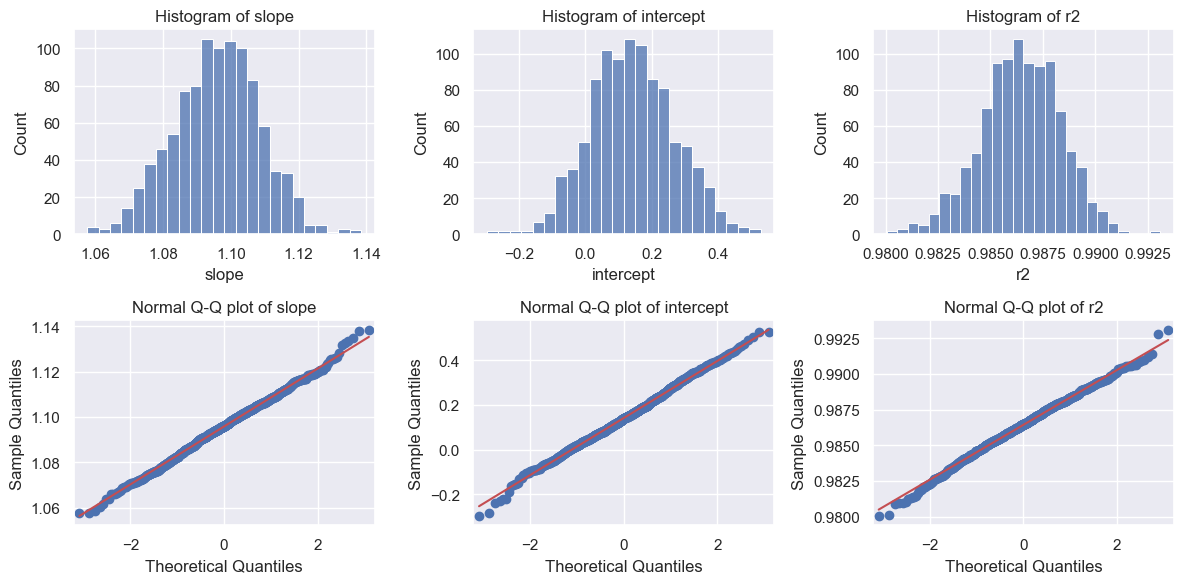

In [6]:
# Check normality of experiment 01 fitting parameters with histogram and Q-Q plot.
data = df_results[df_results['experiment']=='01']
print('Experiment 01 fitting parameters normality check:')
parameters = ['slope', 'intercept', 'r2']
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
for i1 in range(2):
    for i2 in range(3):
        ax = axs[i1, i2]
        para = parameters[i2]
        if i1 == 0: # histgram
            sns.histplot(data, x=para, ax=ax)
            ax.set_title('Histogram of ' + para)
        else: # Q-Q plot
            sm.qqplot(data[para], line='s', ax=ax)
            ax.set_title('Normal Q-Q plot of ' + para)
plt.tight_layout()
plt.show()

Above figure confirms that experiment 01 parameters (slope, intercept and r2) do follow normal distribution. We can confirm experiment 02 and 03 parameters normality in the same way (not shown here).

Now we are ready to do hypothesis test.

In [7]:
def parameter_test(tests, df_results):
    """t-test for parameter mean and Bartlett's test for parameter variance

    Return
    ---
    - [DataFrame]: summary table of p value

    Parameter
    ---
    - tests [list]: shape (n, 2)
      - example: tests = [('01', '02'), ('02', '03')]
        - tests to be done: exp01 vs. exp02, exp02 vs. exp03
    - df_results [DataFrome]: fitting results
    """
    test_results = {'test group': [],
                    'slope mean': [],
                    'slope std': [],
                    'intercept mean': [],
                    'intercept std': [],
                    'r2 mean': [],
                    'r2 std': []}

    for s1, s2 in tests:
        test_results['test group'].append(s1 + ' vs. ' + s2)
        for para in ['slope', 'intercept', 'r2']:
            sample1 = df_results[df_results['experiment']==s1][para]
            sample2 = df_results[df_results['experiment']==s2][para]
            test_results[para+' mean'].append(f'p = {stats.ttest_ind(sample1, sample2)[1]:.4f}')
            test_results[para+' std'].append(f'p = {stats.bartlett(sample1, sample2)[1]:.4f}')

    # return fitting result (p value) table
    return pd.DataFrame(test_results).set_index('test group')

# t-test and Bartlett’s test for experiment 01~03
alpha = 0.05
tests = [('01', '02'), ('02', '03'), ('01', '03')]
parameter_test(tests, df_results)

,slope mean,slope std,intercept mean,intercept std,r2 mean,r2 std
test group,,,,,,
01 vs. 02,p = 0.0130,p = 0.0001,p = 0.0135,p = 0.0001,p = 0.0000,p = 0.0000
02 vs. 03,p = 0.2980,p = 0.1710,p = 0.2965,p = 0.1570,p = 0.0000,p = 0.0020
01 vs. 03,p = 0.0004,p = 0.0000,p = 0.0005,p = 0.0000,p = 0.0000,p = 0.0000


From above testing p values, we can see experiment 02 and 03 slope and intercept are NOT significantly different in means and variations. Experiment 01 fitting coeffecients and r2 score are significantly better than both 02 and 03.

**Conclusion**

With control of total sample size and ladder range, less steps can yield more accurate correlation result.

## Direct *vs.* Aggregate Fitting

**Scenario**

Albert decides to do machine correlation with 3 steps ladder samples. He approaches Prod engineer Ben for sample making. However, Ben rejects Albert's proposal to make 35 samples per step due to too long line down time is required. He is only willing to make 5 samples per step.

With total sample size reducing from 105 to 15, can Albert still get good correlation? Let's do below virtual experiment to find out.

* **Experiment 04**:
  * 3 steps: center, +/- 6 sigma
  * 5 samples per step

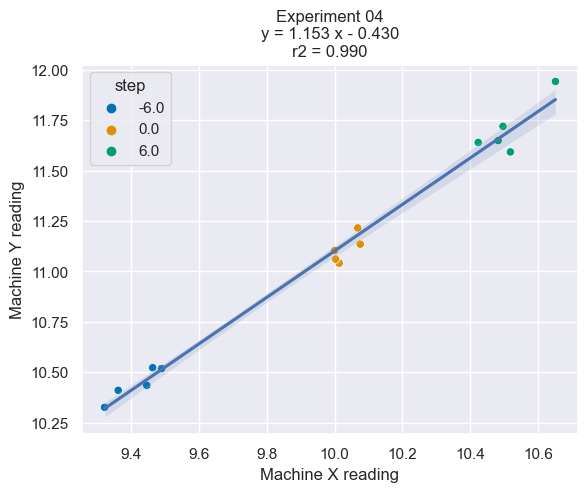

In [8]:
# define experiment 04
def exp04():
    """Do experiment 04 once, with fitting

    Return
    ---
    - (fit_results [tuple], df [DataFrame])
      - fit_results: (slope [num], intercept [num], r2 [num])
      - df: ['step', 'X_true', 'Y_true', 'X_reading', 'Y_reading']
    """
    design = [[-6.0, 5], [0.0, 5], [6.0, 5]]
    df = experiment(design)
    return linear_fit(df), df

# do experiment 04 once and plot result
(slope, intercept, r2), df4 = exp04()
sns.scatterplot(df4, x='X_reading', y='Y_reading', hue='step', palette='colorblind')
sns.regplot(df4, x='X_reading', y='Y_reading', scatter=False)
plt.xlabel('Machine X reading')
plt.ylabel('Machine Y reading')
plt.title(f'Experiment 04\ny = {slope:.3f} x ' 
          + ('+' if intercept>=0 else '-') 
          + f' {abs(intercept):.3f}\nr2 = {r2:.3f}')
plt.show()

$\small R^{2}=0.990$, surprisingly good! Even better than experiment 01~03 (n = 105). How is it possible that better correlation can be achieved with smaller sample size? Maybe this is just one time good chance...

Alber shows Ben the concern. After reviewing this virtual experiment result, Ben says: "Why don't you aggregate the points from the same step samples? The $\small R^{2}$ score will continue to improve."

Really??? Albert seriously doubt it. Anyway, let's do another virtual experiment to find out.

* **Experiment 05**:
  * Use experiment 04 sample data
  * Aggregate all points from same step by mean value, which reducing the fitting points from 15 to 3 only
  * Do linear fitting using the aggregated points

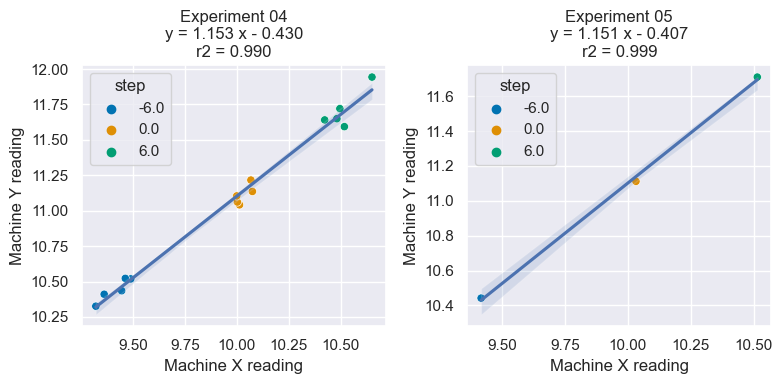

In [9]:
# define experiment 05
def exp05(df4):
    """Do experiment 05 once, with fitting

    Return
    ---
    - (fit_results [tuple], df [DataFrame])
      - fit_results: (slope [num], intercept [num], r2 [num])
      - df: ['step', 'X_true', 'Y_true', 'X_reading', 'Y_reading']

    Parameter
    ---
    - df4 [DataFrame]: df from experiment 04
    """
    df = df4.groupby(by='step').mean().reset_index()
    return linear_fit(df), df

# do experiment 05 once and plot result
(slope_, intercept_, r2_), df5 = exp05(df4)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (8, 4))
sns.scatterplot(df4, x='X_reading', y='Y_reading', hue='step', palette='colorblind', ax=axs[0])
sns.regplot(df4, x='X_reading', y='Y_reading', scatter=False, ax=axs[0])
axs[0].set_xlabel('Machine X reading')
axs[0].set_ylabel('Machine Y reading')
axs[0].set_title(f'Experiment 04\ny = {slope:.3f} x ' 
                 + ('+' if intercept>=0 else '-') 
                 + f' {abs(intercept):.3f}\nr2 = {r2:.3f}')
sns.scatterplot(df5, x='X_reading', y='Y_reading', hue='step', palette='colorblind', ax=axs[1])
sns.regplot(df5, x='X_reading', y='Y_reading', scatter=False, ax=axs[1])
axs[1].set_xlabel('Machine X reading')
axs[1].set_ylabel('Machine Y reading')
axs[1].set_title(f'Experiment 05\ny = {slope_:.3f} x ' 
                 + ('+' if intercept_>=0 else '-') 
                 + f' {abs(intercept_):.3f}\nr2 = {r2_:.3f}')
plt.tight_layout()
plt.show()

Wow! $\small R^{2}$ does show improvement from 0.990 to 0.999!

But wait! Closely judging the fitting coefficients, they are not so close to true correlation values. Especially the fitted intercept is -0.407, which is quite far away from the true value +0.1.

Why good $\small R^{2}$ but poor coefficients? Is it just one time random error? Let's repeat experiment 04 and 05 1000 times to find out.

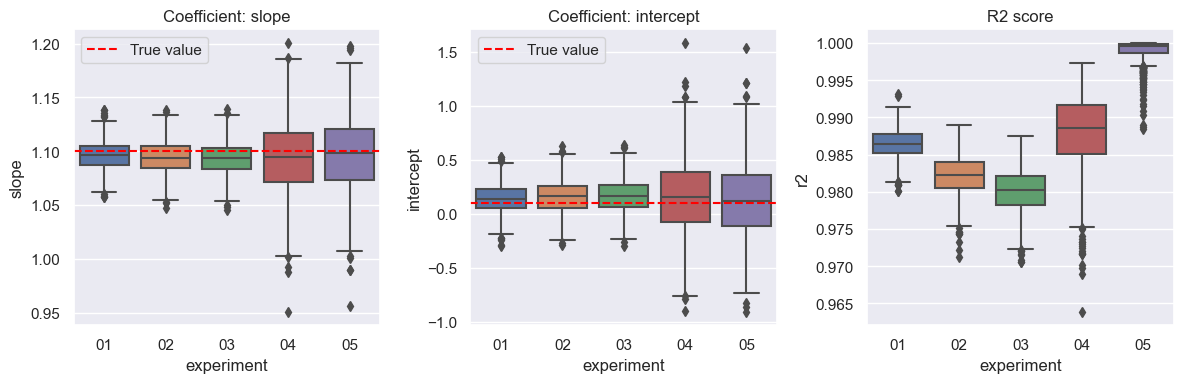

Experiment 1~5 Summary:


slope           intercept                  r2          
                mean       std      mean       std      mean       std
experiment                                                            
01          1.095837  0.012765  0.141735  0.127798  0.986438  0.001924
02          1.094323  0.014421  0.156810  0.144440  0.982184  0.002633
03          1.093636  0.015059  0.163711  0.151058  0.980143  0.002904
04          1.094529  0.033532  0.154177  0.335031  0.987913  0.004973
05          1.097708  0.033685  0.122379  0.336499  0.999022  0.001435

In [10]:
# Repeating experiment 04 and 05 each 1000 (or exp_n) times
results_dict = {'experiment': [], 'slope': [], 'intercept': [], 'r2': []}
exp_comment_dict['04'] = '3 steps +/- 6 sigma, 5 pts per step'
exp_comment_dict['05'] = 'same as exp04, aggegrate fitting'

for i in range(exp_n):
    ## do experiment 04
    (slope, intercept, r2), df4 = exp04()
    results_dict['experiment'].append('04')
    results_dict['slope'].append(slope)
    results_dict['intercept'].append(intercept)
    results_dict['r2'].append(r2)
    ## do experiment 05
    slope, intercept, r2 = exp05(df4)[0]
    results_dict['experiment'].append('05')
    results_dict['slope'].append(slope)
    results_dict['intercept'].append(intercept)
    results_dict['r2'].append(r2)

# display results

df_results = pd.concat([df_results, pd.DataFrame(results_dict)], axis=0)
df_summary = df_results.groupby('experiment').agg(['mean', 'std'])

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
sns.boxplot(df_results, x='experiment', y='slope', ax=axs[0])
sns.boxplot(df_results, x='experiment', y='intercept', ax=axs[1])
sns.boxplot(df_results, x='experiment', y='r2', ax=axs[2])
axs[0].set_title('Coefficient: slope')
axs[1].set_title('Coefficient: intercept')
axs[2].set_title('R2 score')
axs[0].axhline(1.1, color='red', linestyle='--', label='True value')
axs[1].axhline(0.1, color='red', linestyle='--', label='True value')
axs[0].legend()
axs[1].legend()
plt.tight_layout()
plt.show()

print('Experiment 1~5 Summary:')
df_summary

**Sample size** effect is very obvious!  
* Experiment 04, 05 (n = 15) show much wider slope and intercept variance than experiment 01, 02, 03 (n = 105), indicating poorer fitting quality.
* However, $\small R^{2}$ scores look higher with smaller sample size, especially experiment 06 (aggregate fitting) $\small R^{2}$ is very high.

To further understand if aggergate fitting method can improve fitting coefficients, let's do statistical tests similar to last time.

In [11]:
# t-test and Bartlett’s test for experiment 01, 04, 05
alpha = 0.05
tests = [('01', '04'), ('01', '05'),('04', '05')]
parameter_test(tests, df_results)

,slope mean,slope std,intercept mean,intercept std,r2 mean,r2 std
test group,,,,,,
01 vs. 04,p = 0.2493,p = 0.0000,p = 0.2727,p = 0.0000,p = 0.0000,p = 0.0000
01 vs. 05,p = 0.1006,p = 0.0000,p = 0.0892,p = 0.0000,p = 0.0000,p = 0.0000
04 vs. 05,p = 0.0346,p = 0.8859,p = 0.0343,p = 0.8901,p = 0.0000,p = 0.0000


**Conclusion**

* Judging by fitting coefficient variance:
    * Smaller sample size is poorer
    * Aggregate fitting method is **NOT** significantly different from normal fitting method
* Judging by fitting coefficient mean:
    * Aggregate fitting method is slightly (yet significantly) more close to true values
    * Why the coefficient mean values are not always close to true values? We will discuss this topic later.
* $\small R^{2}$ score does **NOT** tell machine to machine correlation method quality

<br>

**How to understand $\small R^{2}$ trend?**

Accordint to theory, $\small R^{2}$ is the ratio of total y value variance explained by the regression model.

$$\begin{align*}
R^{2} & =\  \frac{explained\ variance}{total\ variance} \\
 & =\  \frac{explained\ variance}{explained\ variance\ +\ machine\ variance\ +\ sample\ variance\ \times\ sample\ size}
\end{align*}$$

* Reduce sample size will effectively reduce the enominator of above equation, resulting in higher $\small R^2$.

* Using aggregate fitting method actually reduces both $\color{blue} sample\ variance$ and $\color{blue}sample\ size$, thus resulting in even higher $\small R^2$.

**NOTE**: above explaination is not rigorous as the model explained variance is also affected by sample size. I will not dig into that detail and leave it as homework to mathematicians (if any) reading this post (😂😂🤣).

<br>

## Argument on aggregate fitting method benefits

**Scenario**

Albert shows above analysis to Ben, who agrees that experiment 05 does not show better machine correlation than experiment 04. However, he still argues that aggregate fitting method has benefits in below scenarios.  
1. Sample size is not balanced for all steps.
2. Measurement is destructive and sister samples have to be sent for Machine X & Y respectively.

### - Imbalanced sample size per step

According to Ben, even though he can make 15 samples with 5 per step, there is no guarantee Albert can finally obtain that many data points. Sample mishandling and measurement machine trouble may happen and eventually resulting in imbalanced sample size per step.

Ben argues that using aggregate fitting method the effective sample size per step is reduced to 1, thus always balanced and fitting quality can be improved.

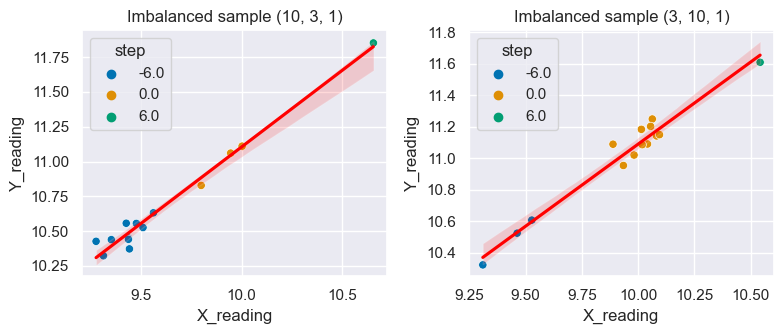

In [12]:
# show example of imbalanced experiment
df1 = experiment([[-6., 10], [0., 3], [6., 1]])
df2 = experiment([[-6., 3], [0., 10], [6., 1]])
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,3.5))
sns.scatterplot(df1, x='X_reading', y='Y_reading', hue='step', palette='colorblind', ax=axs[0])
sns.regplot(df1, x='X_reading', y='Y_reading', scatter=False, line_kws={"color": "red"}, ax=axs[0])
axs[0].set_title('Imbalanced sample (10, 3, 1)')
sns.scatterplot(df2, x='X_reading', y='Y_reading', hue='step', palette='colorblind', ax=axs[1])
sns.regplot(df2, x='X_reading', y='Y_reading', scatter=False, line_kws={"color": "red"}, ax=axs[1])
axs[1].set_title('Imbalanced sample (3, 10, 1)')
plt.tight_layout()
plt.show()

Above shows 2 examples of imbalanced sample set with linear regression fitting. The shaded area is the confidence interval (CI). It does show clear sample imbalance effect. The CI is narrower where the data points are denser.

Below figure shows the aggregate fitting method with these example data sets.

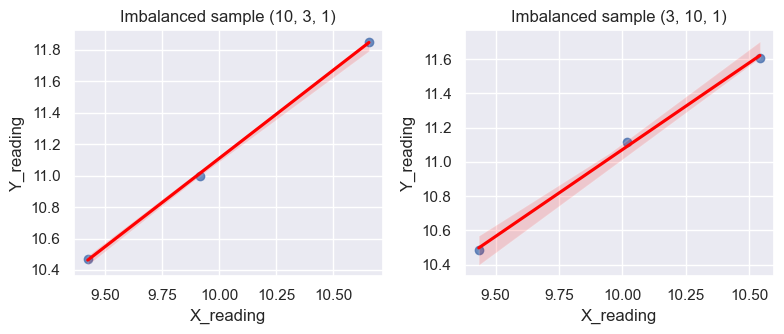

In [13]:
# redo fitting using aggerage method
df1_ = df1.groupby(by='step').mean()
df2_ = df2.groupby(by='step').mean()
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,3.5))
# sns.scatterplot(df1, x='X_reading', y='Y_reading', hue='step', palette='colorblind', ax=axs[0])
sns.regplot(df1_, x='X_reading', y='Y_reading', line_kws={"color": "red"}, ax=axs[0])
axs[0].set_title('Imbalanced sample (10, 3, 1)')
# sns.scatterplot(df2, x='X_reading', y='Y_reading', hue='step', palette='colorblind', ax=axs[1])
sns.regplot(df2_, x='X_reading', y='Y_reading', line_kws={"color": "red"}, ax=axs[1])
axs[1].set_title('Imbalanced sample (3, 10, 1)')
plt.tight_layout()
plt.show()

Hmmm... Left one shows improvement in CI but right one is slightly worse? Not conclusive.

Let's define new virtual experiments and run 1000 times to check statistical significance.

* **Experiment 06**:
  * 3 steps: center, +/- 6 sigma
  * Randomly 2~5 samples per step
* **Experiment 07**:
  * Use experiment 06 sample data
  * Aggregate all points from same step by mean value
  * Do linear fitting using the aggregated points

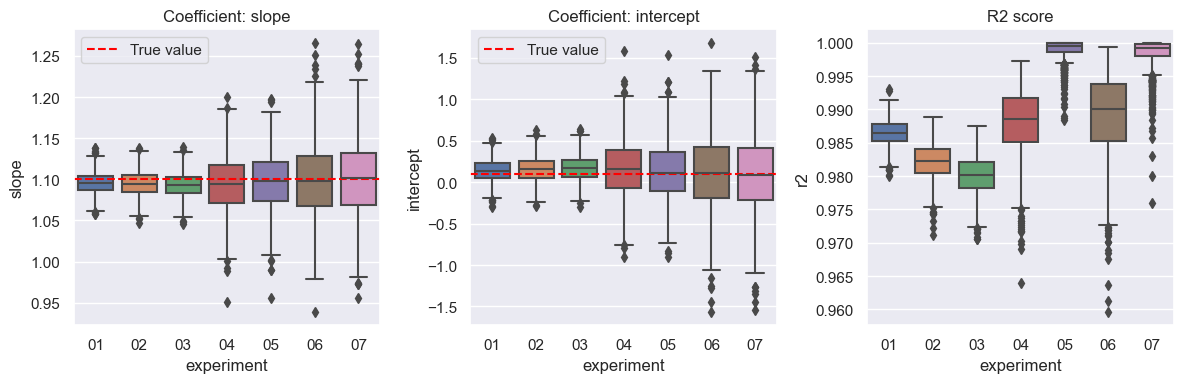

Experiment 4~7 Summary:


slope           intercept                  r2          
                mean       std      mean       std      mean       std
experiment                                                            
04          1.094529  0.033532  0.154177  0.335031  0.987913  0.004973
05          1.097708  0.033685  0.122379  0.336499  0.999022  0.001435
06          1.097798  0.045031  0.120706  0.450855  0.988971  0.006301
07          1.100559  0.046449  0.093249  0.464774  0.998411  0.002331

In [14]:
# define experiment 06 & 07
def exp06():
    """Do experiment 06 once, with fitting

    Return
    ---
    - (fit_results [tuple], df [DataFrame])
      - fit_results: (slope [num], intercept [num], r2 [num])
      - df: ['step', 'X_true', 'Y_true', 'X_reading', 'Y_reading']
    """
    design = [[-6.0, rng.integers(2,5)], [0.0, rng.integers(2,5)], [6.0, rng.integers(2,5)]]
    df = experiment(design)
    return linear_fit(df), df

def exp07(df6):
    """Do experiment 07 once, with fitting

    Return
    ---
    - (fit_results [tuple], df [DataFrame])
      - fit_results: (slope [num], intercept [num], r2 [num])
      - df: ['step', 'X_true', 'Y_true', 'X_reading', 'Y_reading']

    Parameter
    ---
    - df6 [DataFrame]: df from experiment 04
    """
    df = df6.groupby(by='step').mean().reset_index()
    return linear_fit(df), df

# Repeating experiment 06 and 07 each 1000 (or exp_n) times
results_dict = {'experiment': [], 'slope': [], 'intercept': [], 'r2': []}
exp_comment_dict['06'] = '3 steps +/- 6 sigma, 2~5 pts per step'
exp_comment_dict['07'] = 'same as exp06, aggegrate fitting'

for i in range(exp_n):
    ## do experiment 06
    (slope, intercept, r2), df6 = exp06()
    results_dict['experiment'].append('06')
    results_dict['slope'].append(slope)
    results_dict['intercept'].append(intercept)
    results_dict['r2'].append(r2)
    ## do experiment 07
    slope, intercept, r2 = exp07(df6)[0]
    results_dict['experiment'].append('07')
    results_dict['slope'].append(slope)
    results_dict['intercept'].append(intercept)
    results_dict['r2'].append(r2)

# display results

df_results = pd.concat([df_results, pd.DataFrame(results_dict)], axis=0)
df_summary = df_results.groupby('experiment').agg(['mean', 'std'])

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
sns.boxplot(df_results, x='experiment', y='slope', ax=axs[0])
sns.boxplot(df_results, x='experiment', y='intercept', ax=axs[1])
sns.boxplot(df_results, x='experiment', y='r2', ax=axs[2])
axs[0].set_title('Coefficient: slope')
axs[1].set_title('Coefficient: intercept')
axs[2].set_title('R2 score')
axs[0].axhline(1.1, color='red', linestyle='--', label='True value')
axs[1].axhline(0.1, color='red', linestyle='--', label='True value')
axs[0].legend()
axs[1].legend()
plt.tight_layout()
plt.show()

print('Experiment 4~7 Summary:')
df_summary.iloc[-4:]

Judging by fitting coefficient variance, experiment 07 is slightly worse than 06.

Let's do statistical hypothesis test to find out if the difference is significant.

In [15]:
# t-test and Bartlett’s test for experiment 04, 06, 07
alpha = 0.05
tests = [('04', '06'), ('04', '07'),('06', '07')]
parameter_test(tests, df_results)

,slope mean,slope std,intercept mean,intercept std,r2 mean,r2 std
test group,,,,,,
04 vs. 06,p = 0.0658,p = 0.0000,p = 0.0597,p = 0.0000,p = 0.0000,p = 0.0000
04 vs. 07,p = 0.0009,p = 0.0000,p = 0.0008,p = 0.0000,p = 0.0000,p = 0.0000
06 vs. 07,p = 0.1773,p = 0.3273,p = 0.1801,p = 0.3367,p = 0.0000,p = 0.0000


* Experiment 06 (imbalanced sample) coefficient variances are significantly larger than experiment 04 (balanced sample), due to smaller sample size.
* Experiment 07 (aggregate fitting) coefficent distributions are not significantly different from experiment 06.

**Conclusion**  
* Aggregate fitting method can **NOT** improve machine correlation quality when sample size per step is imbalanced.

<br>

### - Machine correlation for destructive measurements

When measurement is destructive, it is impossible to measure same sample by both Machine X and Y, so no apple to apple comparison. In order to get correlation, traditionally samples from same box (sister sample) will be sent to both machines respectively with the assumption of small variance, though it can still be quite significant.

In this situation, Ben argues that it is not correct to simply assume same value between sister samples and pair them up for machine correlation calculation. Instead, aggregate all points in each step can remove this sister sample variance since aggregated value is always close to step target and you don't have to assume which sample from Y measurement is sister to another sample from X measurement.

While Ben's argument sounds plausible, Albert doubts how they are different from experiment 04 vs. 05 from math calculation point of view? Anyway, let's do new virtual experiments to find out.

* **Experiment 08**:
  * 3 steps: center, +/- 6 sigma
  * 5 samples per step
  * Send sister samples for Machine X and Y respectively
* **Experiment 09**:
  * Use experiment 08 sample data
  * Aggregate all points from same step by mean value
  * Do linear fitting using the aggregated points

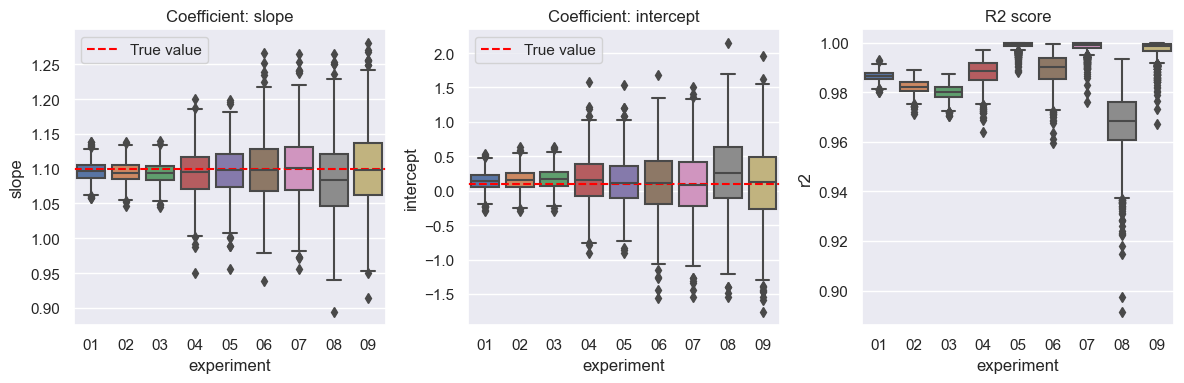

Experiment 4, 8, 9 Summary:


,"(slope, mean)","(slope, std)","(intercept, mean)","(intercept, std)","(r2, mean)","(r2, std)",comment
experiment,,,,,,,
04,1.094529,0.033532,0.154177,0.335031,0.987913,0.004973,"3 steps +/- 6 sigma, 5 pts per step"
08,1.085005,0.054171,0.249702,0.541271,0.967135,0.013194,"3 steps +/- 6 sigma, 5 pts per step, use siste..."
09,1.099749,0.055407,0.102231,0.553900,0.997401,0.003626,"same as exp08, aggegrate fitting"


In [16]:
# define experiment 08 & 09
def exp08():
    """Do experiment 08 once, with fitting

    Return
    ---
    - (fit_results [tuple], df [DataFrame])
      - fit_results: (slope [num], intercept [num], r2 [num])
      - df: ['step', 'X_true', 'Y_true', 'X_reading', 'Y_reading']
    """
    design = [[-6.0, 5], [0.0, 5], [6.0, 5]]
    df = experiment(design, use_sister=True)
    return linear_fit(df), df

def exp09(df8):
    """Do experiment 09 once, with fitting

    Return
    ---
    - (fit_results [tuple], df [DataFrame])
      - fit_results: (slope [num], intercept [num], r2 [num])
      - df: ['step', 'X_true', 'Y_true', 'X_reading', 'Y_reading']

    Parameter
    ---
    - df8 [DataFrame]: df from experiment 08
    """
    df = df8.groupby(by='step').mean().reset_index()
    return linear_fit(df), df

# Repeating experiment 08 and 09 each 1000 (or exp_n) times
results_dict = {'experiment': [], 'slope': [], 'intercept': [], 'r2': []}
exp_comment_dict['08'] = '3 steps +/- 6 sigma, 5 pts per step, use sister samples'
exp_comment_dict['09'] = 'same as exp08, aggegrate fitting'

for i in range(exp_n):
    ## do experiment 08
    (slope, intercept, r2), df8 = exp08()
    results_dict['experiment'].append('08')
    results_dict['slope'].append(slope)
    results_dict['intercept'].append(intercept)
    results_dict['r2'].append(r2)
    ## do experiment 09
    slope, intercept, r2 = exp09(df8)[0]
    results_dict['experiment'].append('09')
    results_dict['slope'].append(slope)
    results_dict['intercept'].append(intercept)
    results_dict['r2'].append(r2)

# display results

df_results = pd.concat([df_results, pd.DataFrame(results_dict)], axis=0)
df_summary = df_results.groupby('experiment').agg(['mean', 'std'])

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
sns.boxplot(df_results, x='experiment', y='slope', ax=axs[0])
sns.boxplot(df_results, x='experiment', y='intercept', ax=axs[1])
sns.boxplot(df_results, x='experiment', y='r2', ax=axs[2])
axs[0].set_title('Coefficient: slope')
axs[1].set_title('Coefficient: intercept')
axs[2].set_title('R2 score')
axs[0].axhline(1.1, color='red', linestyle='--', label='True value')
axs[1].axhline(0.1, color='red', linestyle='--', label='True value')
axs[0].legend()
axs[1].legend()
plt.tight_layout()
plt.show()

print('Experiment 4, 8, 9 Summary:')
df_comment = pd.DataFrame({'experiment': [key for key in exp_comment_dict],
                           'comment': [exp_comment_dict[key] for key in exp_comment_dict]}
                         ).set_index('experiment')
df_summary = pd.concat([df_summary, df_comment], axis=1)
pd.concat([df_summary.iloc[3:4], df_summary.iloc[-2:]])

In [17]:
# t-test and Bartlett’s test for experiment 04, 08, 09
alpha = 0.05
tests = [('04', '08'), ('04', '09'),('08', '09')]
parameter_test(tests, df_results)

,slope mean,slope std,intercept mean,intercept std,r2 mean,r2 std
test group,,,,,,
04 vs. 08,p = 0.0000,p = 0.0000,p = 0.0000,p = 0.0000,p = 0.0000,p = 0.0000
04 vs. 09,p = 0.0109,p = 0.0000,p = 0.0112,p = 0.0000,p = 0.0000,p = 0.0000
08 vs. 09,p = 0.0000,p = 0.4760,p = 0.0000,p = 0.4662,p = 0.0000,p = 0.0000


* Judging by fitting coefficient variance:  
  * Experiment 08 is worse than experiment 04.
    * It is easy to understand since sending sister samples instead of same sample to Machine X and Y respectively definitely introduce higher error.
  * Experiment 09 is slightly (but significantly) worse than experiment 08.
* Judging by fitting coefficient mean:
  * Small difference (though significant) is observed.

**Conclusion**  
* Aggegrate fitting does **NOT** improve machine correlation with sister samples, the performance is rather comparable to traditional fitting method.

<br>

## Extremely imbalanced sample distribution

**Scenario**

Finally Albert decides to fix to experiment 04 condition, i.e., make 3 steps ladder samples of 5 per step with target interval of 6 process sigma. He also takes very good care of all samples and make sure they are handled properly for Machine X and Y measurements. He does the fitting with OLS linear regression model.

When he presents the result to his manager Mary, she is not satisfied as the sample size is too small.

"I know Prod team had difficulty to allocate resource to make more samples." says Mary, "Why don't you use the existing Prod data? For every lot produced, they always send samples for both Machine X and Y measurements. They are effectively sister samples which you can include in your correlation work. The correlation will surely be more accurate with more data."

It sounds like a great idea! How much improvement can it achieve? Let's do a new virtual experiment!

* **Experiment 10**:
  * Ladder samples
    * 3 steps: center, +/- 6 sigma
    * 5 samples per step
  * Prod data
    * 1 step only: targetting center
    * 200 pairs of sister samples for Machine X and Y respectively

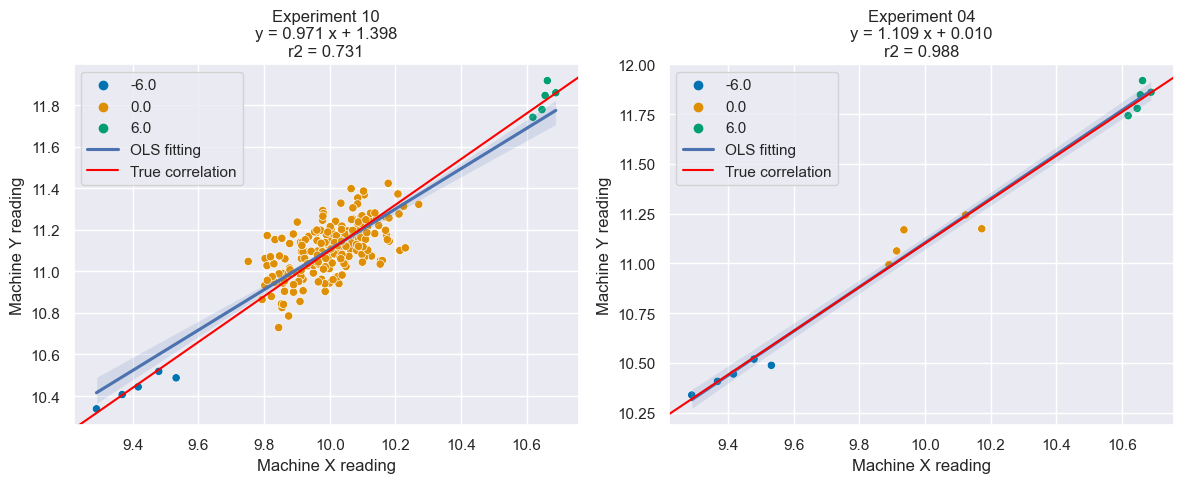

In [18]:
# define experiment 10
def exp10():
    """Do experiment 10 once, with fitting

    Return
    ---
    - (fit_results [tuple], df [DataFrame])
      - fit_results: (slope [num], intercept [num], r2 [num])
      - df: ['step', 'X_true', 'Y_true', 'X_reading', 'Y_reading']
    """
    # make ladder samples
    design1 = [[-6.0, 5], [0.0, 5], [6.0, 5]]
    df1 = experiment(design1, use_sister=False)

    # retrieve Prod data
    design2 = [[0.0, 200]]
    df2 = experiment(design2, use_sister=True)

    # combine data
    df = pd.concat([df1, df2], axis=0)
    return linear_fit(df), df

# do experiment 10 and 04 once with same data
(slope, intercept, r2), df10 = exp10()
df4 = df10.iloc[:15]
slope_, intercept_, r2_ = linear_fit(df4)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# plot experiment 10
sns.scatterplot(df10, x='X_reading', y='Y_reading', hue='step', palette='colorblind', ax=axs[0])
sns.regplot(df10, x='X_reading', y='Y_reading', scatter=False, label='OLS fitting', ax=axs[0])
axs[0].axline((10, 11.1), (10.1, 11.21), color='red', label='True correlation')
axs[0].set_xlabel('Machine X reading')
axs[0].set_ylabel('Machine Y reading')
axs[0].set_title(f'Experiment 10\ny = {slope:.3f} x ' 
                 + ('+' if intercept>=0 else '-') 
                 + f' {abs(intercept):.3f}\nr2 = {r2:.3f}')
axs[0].legend()

# plot experiment 04
sns.scatterplot(df4, x='X_reading', y='Y_reading', hue='step', palette='colorblind', ax=axs[1])
sns.regplot(df4, x='X_reading', y='Y_reading', scatter=False, label='OLS fitting', ax=axs[1])
axs[1].axline((10, 11.1), (10.1, 11.21), color='red', label='True correlation')
axs[1].set_xlabel('Machine X reading')
axs[1].set_ylabel('Machine Y reading')
axs[1].set_title(f'Experiment 04\ny = {slope_:.3f} x ' 
                 + ('+' if intercept_>=0 else '-') 
                 + f' {abs(intercept_):.3f}\nr2 = {r2_:.3f}')
axs[1].legend()

plt.tight_layout()
plt.show()

Wait, something is wrong! Experiment 10 fitted line slope and intercept is very far from true correlation, much worse than experiment 04 without those Prod data!

But, ***why???***

This surprising virtual experiment result is a big concern, Albert starts to brain storm for hypotheses:
1.  Maybe this is just one time random poor result. We are just super unlucky.
2.  Maybe the extremely imbalanced data distribution (super high density at center) causes calculation issue? If this is true, how to solve it?
    * Maybe we can try aggregate fitting method? It should rebalance the data distribution.
    * Maybe we can also try to put a weight on each point based on local data density?

* **Experiment 11**:
  * Same sample data from experiment 10
  * Use aggregate fitting method
* **Experiment 12**:
  * Same sample data from experiment 10
  * Use weighted least square (WLS) linear regression model fitting
  * Use the reciprocal of density as weight

Let's do experiment 10 to 12 1000 times.

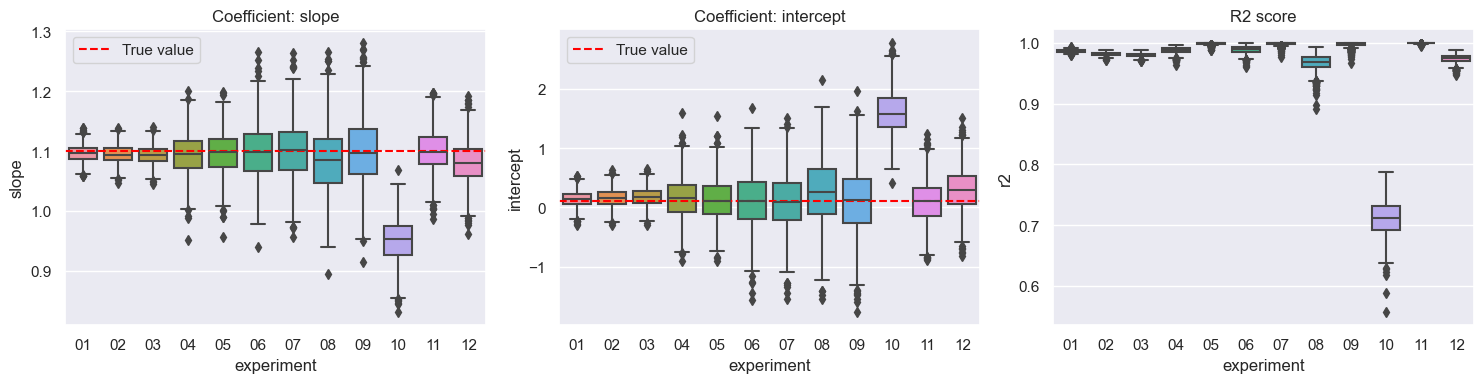

Experiment 4, 5, 10, 11, 12 Summary:


,"(slope, mean)","(slope, std)","(intercept, mean)","(intercept, std)","(r2, mean)","(r2, std)",comment
experiment,,,,,,,
04,1.094529,0.033532,0.154177,0.335031,0.987913,0.004973,"3 steps +/- 6 sigma, 5 pts per step"
05,1.097708,0.033685,0.122379,0.336499,0.999022,0.001435,"same as exp04, aggegrate fitting"
10,0.950521,0.034387,1.594217,0.343961,0.710622,0.029406,"3 steps +/- 6 sigma, 5 pts per step, + 200 pai..."
11,1.100135,0.034888,0.098406,0.348879,0.999632,0.000509,"same as exp10, aggegrate fitting"
12,1.080672,0.034309,0.292919,0.343074,0.974337,0.006730,"same as exp10, use reciprocal of density as we..."


In [19]:
# define experiment 11 & 12
def exp11(df10):
    """Do experiment 11 once, with fitting

    Return
    ---
    - (fit_results [tuple], df [DataFrame])
      - fit_results: (slope [num], intercept [num], r2 [num])
      - df: ['step', 'X_true', 'Y_true', 'X_reading', 'Y_reading']

    Parameter
    ---
    - df10 [DataFrame]: df from experiment 10
    """
    df = df10.groupby(by='step').mean().reset_index()
    return linear_fit(df), df

def exp12(df10):
    """Do experiment 12 once, with fitting

    Return
    ---
    - (fit_results [tuple], df [DataFrame])
      - fit_results: (slope [num], intercept [num], r2 [num])
      - df: ['step', 'X_true', 'Y_true', 'X_reading', 'Y_reading']

    Parameter
    ---
    - df10 [DataFrame]: df from experiment 10
    """
    df = df10.copy()
    kde = KernelDensity(bandwidth=process_sigma).fit(np.array(df['X_reading']).reshape(-1, 1))
    df['weight'] = 1 / np.exp(kde.score_samples(np.array(df['X_reading']).reshape(-1, 1)))
    return linear_fit(df), df

# Repeating experiment 10, 11 and 12 each 1000 (or exp_n) times
results_dict = {'experiment': [], 'slope': [], 'intercept': [], 'r2': []}
exp_comment_dict['10'] = '3 steps +/- 6 sigma, 5 pts per step, + 200 pairs of Prod samples'
exp_comment_dict['11'] = 'same as exp10, aggegrate fitting'
exp_comment_dict['12'] = 'same as exp10, use reciprocal of density as weight'

for i in range(exp_n):
    ## do experiment 10
    (slope, intercept, r2), df10 = exp10()
    results_dict['experiment'].append('10')
    results_dict['slope'].append(slope)
    results_dict['intercept'].append(intercept)
    results_dict['r2'].append(r2)
    ## do experiment 11
    slope, intercept, r2 = exp11(df10)[0]
    results_dict['experiment'].append('11')
    results_dict['slope'].append(slope)
    results_dict['intercept'].append(intercept)
    results_dict['r2'].append(r2)
    ## do experiment 12
    slope, intercept, r2 = exp12(df10)[0]
    results_dict['experiment'].append('12')
    results_dict['slope'].append(slope)
    results_dict['intercept'].append(intercept)
    results_dict['r2'].append(r2)

# display results

df_results = pd.concat([df_results, pd.DataFrame(results_dict)], axis=0)
df_summary = df_results.groupby('experiment').agg(['mean', 'std'])

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
sns.boxplot(df_results, x='experiment', y='slope', ax=axs[0])
sns.boxplot(df_results, x='experiment', y='intercept', ax=axs[1])
sns.boxplot(df_results, x='experiment', y='r2', ax=axs[2])
axs[0].set_title('Coefficient: slope')
axs[1].set_title('Coefficient: intercept')
axs[2].set_title('R2 score')
axs[0].axhline(1.1, color='red', linestyle='--', label='True value')
axs[1].axhline(0.1, color='red', linestyle='--', label='True value')
axs[0].legend()
axs[1].legend()
plt.tight_layout()
plt.show()

print('Experiment 4, 5, 10, 11, 12 Summary:')
df_comment = pd.DataFrame({'experiment': [key for key in exp_comment_dict],
                           'comment': [exp_comment_dict[key] for key in exp_comment_dict]}
                         ).set_index('experiment')
df_summary = pd.concat([df_summary, df_comment], axis=1)
pd.concat([df_summary.iloc[3:5], df_summary.iloc[-3:]], axis=0)

In [20]:
# t-test and Bartlett’s test for experiment 04, 05, 10, 11, 12
alpha = 0.05
tests = [('04', '10'), ('05', '11'), ('10', '11'), ('10', '12'), ('11', '12')]
parameter_test(tests, df_results)

,slope mean,slope std,intercept mean,intercept std,r2 mean,r2 std
test group,,,,,,
04 vs. 10,p = 0.0000,p = 0.4263,p = 0.0000,p = 0.4059,p = 0.0000,p = 0.0000
05 vs. 11,p = 0.1136,p = 0.2676,p = 0.1180,p = 0.2537,p = 0.0000,p = 0.0000
10 vs. 11,p = 0.0000,p = 0.6480,p = 0.0000,p = 0.6537,p = 0.0000,p = 0.0000
10 vs. 12,p = 0.0000,p = 0.9426,p = 0.0000,p = 0.9350,p = 0.0000,p = 0.0000
11 vs. 12,p = 0.0000,p = 0.5971,p = 0.0000,p = 0.5960,p = 0.0000,p = 0.0000


* For experiment 10, the mean values of slope and intercept do deviate significantly from true values.
* Compre experiment 10 to 11 and 12, both aggregate fitting and weighted fitting methods can significanlty improve the accuracy of coefficient means.
  * Aggerate fitting is slightly better than weighted fitting
* Fitted coefficient variances are NOT significantly different among all.
* Experiment 05 and 11 show comparable correlation quality, adding 200 pairs of Prod sample data does **NOT** improve it!

<br>

## OLS Linear Regression is **NOT** suitable for machine correlation

Why Prod samples (i.e. targeting design center, normal distribution with standard deviation equals to process sigma) cannot improve correlation accuracy, rather showing negative effect?

The root cause is ordinary least square (OLS) linear regression model is NOT suitable for machine correlation job. The correct model to use is total least square (TLS) linear regression model.

The figure below demonstrates the fitting results comparison between OLS and TLS with 1000 pairs of Prod samples.

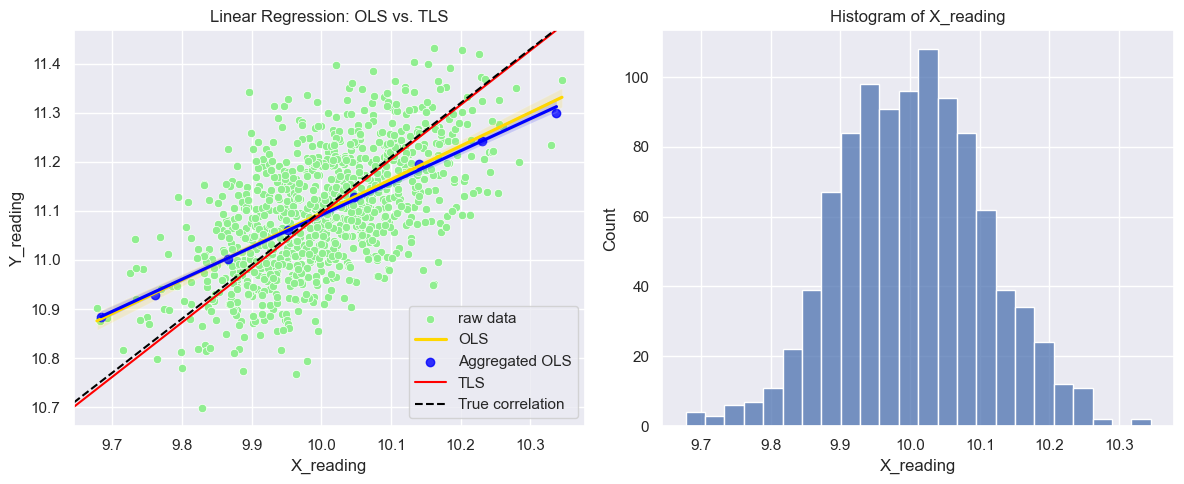

In [21]:
# compare different fitting method

## Make 1000 pairs of sister samples targeting design center
X, Y = make_samples(10, 1000, True)
data = pd.DataFrame({'X_reading': meas_X(X),
                     'Y_reading': meas_Y(get_Y_based_values(Y))})

## Aggregate the points
def map_to_group(x):
    if x < design_center - 3 * process_sigma:
        return '-4'
    elif x < design_center - 2 * process_sigma:
        return '-3'
    elif x < design_center - process_sigma:
        return '-2'
    elif x < design_center:
        return '-1'
    elif x > design_center + 3 * process_sigma:
        return '+4'
    elif x > design_center + 2 * process_sigma:
        return '+3'
    elif x > design_center + process_sigma:
        return '+2'
    else:
        return '+1'
    
data_group = data.copy()
data_group['range'] = data['X_reading'].map(map_to_group)
data_group = data_group.groupby(by='range').mean()

## define total least squared fitting function
## Source: GitHub (https://github.com/RyotaBannai/total-least-squares)
def tls(X,y):
    if len(X.shape) == 1:
        n = 1
        X = X.reshape(len(X),1)
    else:
        n = np.array(X).shape[1] # the number of variable of X
    
    Z = np.vstack((X.T,y)).T
    U, s, Vt = np.linalg.svd(Z, full_matrices=True)

    V = Vt.T
    Vxy = V[:n, n:]
    Vyy = V[n:, n:]
    a_tls = - Vxy  / Vyy # total least squares soln
    
    Xtyt = - Z.dot(V[:,n:]).dot(V[:,n:].T)
    Xt = Xtyt[:,:n] # X error
    y_tls = (X+Xt).dot(a_tls)

    fro_norm = np.linalg.norm(Xtyt, 'fro')#Frobenius norm
    
    return y_tls, X + Xt, a_tls, fro_norm

## Fit with tls
fit = tls(np.array(data['X_reading']), np.array(data['Y_reading']))
y_tls = fit[0].reshape(len(fit[0]))
x_tls = fit[1].reshape(len(fit[1]))

## Plot results
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.scatterplot(data, x='X_reading', y='Y_reading', color='lightgreen', label='raw data', ax=axs[0])
sns.regplot(data, x='X_reading', y='Y_reading', scatter=False, line_kws={'color':'gold'}, label='OLS', ax=axs[0])
sns.regplot(data_group, x='X_reading', y='Y_reading', label='Aggregated OLS', color='blue', ax=axs[0])
axs[0].axline((x_tls[0], y_tls[0]), (x_tls[1], y_tls[1]), color='red', label='TLS')
axs[0].axline((10, 11.1), (10.1, 11.21), color='black', label='True correlation', linestyle='--')
# sns.lineplot(x=[x_tls.min(), x_tls.max()], 
#              y=[y_tls.min(), y_tls.max()],
#              color='red', label='TLS', ax=axs[0])
# sns.lineplot(x=[data['X_reading'].min(), data['X_reading'].max()], 
#              y=[get_Y_based_values(data['X_reading'].min()), get_Y_based_values(data['X_reading'].max())],
#              color='black', label='True correlation', ax=axs[0])
axs[0].legend()
# plt.title('Linear Regression: OLS vs. TLS')
axs[0].set_title('Linear Regression: OLS vs. TLS')
sns.histplot(data, x='X_reading', ax=axs[1])
axs[1].set_title('Histogram of X_reading')
plt.tight_layout()
plt.show()

Clearly TLS fitting line is most close to the true correlation line. OLS fitting line cross other lines at design center, but slope is way off.

**Explanation on OLS *vs.* TLS**  
(For layman only. You may Google for detailed math.)  
* OLS regression takes X values as independent variable, and trying to find best fit for dependent variable Y.
  * It trys to minimize the least squared error between the original point $\small (x,\ y)$ and fitted point $\small (x,\ y')$, which is $\small (y-y')^2$
  * Only Y machine variance is included
* TLS regression takes both X and Y as independent variable, and trying to find best fit of X' and Y'
  * It trys to minimize the least squared error of all variables, which is $\small (x-x')^2 + (y-y')^2$
  * Both X and Y machine variances are included in the calculation, that's why the fitting coefficients are more close to true values
* For machine correlation work, actually our model needs to treat both X and Y as independt variables and the dependent variables are correlation coefficients
  * $\small R^2$ score is a metric to evaluate the quality of the model who takes X as independt variable and Y as dependt variable. That's why we cannot judge machine correlation model quality by $\small R^2$ is NOT correct.
  * The correct metric here should be based on error of coefficients, e.g. $\small (slope-slope')^2+(intercept-intercept')^2$. While we can calculate it in our virtual experiments, it is difficult to apply in real work as you don't know the true value of $\small slope$ and $\small intercept$.

**Limits of TLS linear regression**  
1. Most commonly used data processing softwares (e.g. `Excel`) do NOT readily provide function for TLS linear regression.
2. TLS regression result is NOT robust to linear transformation on variables.
    * If X machine measures a dimension in `cm` and Y machine reads the value in `mm`, obviously the Y machine variance will be exaggerated in the error function $\small (x-x')^2 + (y-y')^2$
    * If you simply convert Y machine readings from unit `mm` to `cm`, TLS fitting results will be different.
    * To achieve best fitting quality, you need to rescale X or Y variables (or both) so that their error contributions are comparable. It can be difficult to do the math, also you need to know the variance of X and Y machine, which may not be easily available in real life.

<br>

## Summary

##### **Common mistakes in measurement machine correlation**

* $\small R^2$ score does NOT tell the correlation quality, i.e. the accuracy of the correlation coefficients.
* OLS linear regression which is commonly used for linear fitting generates system error (i.e. coefficients distribution mean to deviate from true values), due to variance of Machine X is ignored.

##### **Best practice recommendation**

* If you can only use **OLS** fitting due to software (e.g. `Excel`) limit.
  * Make ladder samples for correlation.
    * Sample range the larger the better, must be much larger than Machine X variance.
    * When total range is fixed, increase number of ladder steps does NOT improve correlation quality. 3 or 5 steps are enough.
    * With fixed range and step number, per step sample size is the larger the better.
    * If sample size is imbalanced among all steps, aggregate all data from same step into 1 point before fitting can reduce the system error induced by OLS linear regression model.
  * Avoid doing extrapolation prediction using the fitting result.
    * Meaning the correlation is only valid within sample range.
    * If you try to do prediction outside the sample range, the error may be high due to OLS linear model system error.
  * $\small R^2$ score may be higher with smaller sample size or aggregate fitting method. It does NOT mean better correlation quality or accuracy.
* If you can do **TLS** linear regression.
  * Correlation coefficients accuracy is less sensitive to sample range and distribution uniformity. Especially the distribution mean values shall always be close to true values.
    * There is less limit on doing extrapolation prediction, unlike OLS model.
  * TLS model is not robust to linear transformation of variables, you need to optimize their scales according to machine variance.
    * If difficult to decide the best scale, transform all variables to same scale (i.e. the correlation slope is close to 1) can usually yield reasonably good result.
    * Remember to apply the same variable rescaling when use the fitted model to do prediction in future.